In [1]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.init import kaiming_normal
from torch.utils.data import DataLoader
import numpy as np

In [2]:
prev_timesteps = 3
prediction_steps = 1

train = MoviaBusDataset('../data/train', interpolation=True, prev_timesteps=prev_timesteps, prediction_steps=prediction_steps)
test = MoviaBusDataset('../data/test', interpolation=True, prev_timesteps=prev_timesteps, prediction_steps=prediction_steps)

train.normalize()
test.normalize(train.mean, train.std)



In [3]:
train_DL = DataLoader(train, batch_size=25, shuffle=False)
test_DL = DataLoader(test, batch_size=len(test), shuffle=False)

In [4]:
num_input = (prev_timesteps + 1)

class FNN(nn.Module):
    def __init__(self, num_hidden1):
        super(FNN, self).__init__()
    
        self.l1 = nn.Linear(num_input, num_hidden1)
        self.l2 = nn.Linear(num_hidden1, num_hidden1)
        self.l3 = nn.Linear(num_hidden1, 1)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self,x):
        
        x = self.activation(self.l1(x))
        #x = self.dropout(x)
        x = self.activation(self.l2(x))
        #x = self.dropout(x)
        x = self.l3(x)
        return x

net = FNN(100)

optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-4)
criterion = nn.L1Loss()

In [5]:
net.train()
for epoch in range(100):
    cur_loss = []
    for i , batch in enumerate(train_DL):
        output = net(batch['data'].transpose(2,1)).squeeze()[:,:-1]
        target = batch['target']

        optimizer.zero_grad()
        
        loss = criterion(output, target)   
        loss.backward()
        
        optimizer.step()
  
        cur_loss.append(loss.item())
    if epoch % 5 == 0:
        print("epoch = %2i  loss = %0.3f  output_std = %0.3f" %(epoch, np.mean(cur_loss), output.std().item()))

epoch =  0  loss = 0.722  output_std = 0.331
epoch =  1  loss = 0.712  output_std = 0.317
epoch =  2  loss = 0.707  output_std = 0.326
epoch =  3  loss = 0.705  output_std = 0.337
epoch =  4  loss = 0.704  output_std = 0.341
epoch =  5  loss = 0.703  output_std = 0.338
epoch =  6  loss = 0.703  output_std = 0.337
epoch =  7  loss = 0.702  output_std = 0.335
epoch =  8  loss = 0.702  output_std = 0.336
epoch =  9  loss = 0.702  output_std = 0.338
epoch = 10  loss = 0.701  output_std = 0.338
epoch = 11  loss = 0.701  output_std = 0.339
epoch = 12  loss = 0.701  output_std = 0.340
epoch = 13  loss = 0.701  output_std = 0.340
epoch = 14  loss = 0.701  output_std = 0.338
epoch = 15  loss = 0.701  output_std = 0.341
epoch = 16  loss = 0.701  output_std = 0.340
epoch = 17  loss = 0.701  output_std = 0.341
epoch = 18  loss = 0.701  output_std = 0.338
epoch = 19  loss = 0.700  output_std = 0.338
epoch = 20  loss = 0.700  output_std = 0.338
epoch = 21  loss = 0.700  output_std = 0.338
epoch = 22

In [6]:
net.eval()
for i, batch in enumerate(test_DL):
    
    output = net(batch['data'].transpose(2,1)).squeeze()[:,:-1]
    target = batch['target']
        
    output = output*torch.tensor(train.std) + torch.tensor(train.mean)
    target = target*torch.tensor(train.std) + torch.tensor(train.mean)
    
    loss = criterion(output,target)
    print(loss.item())

1.486466407775879


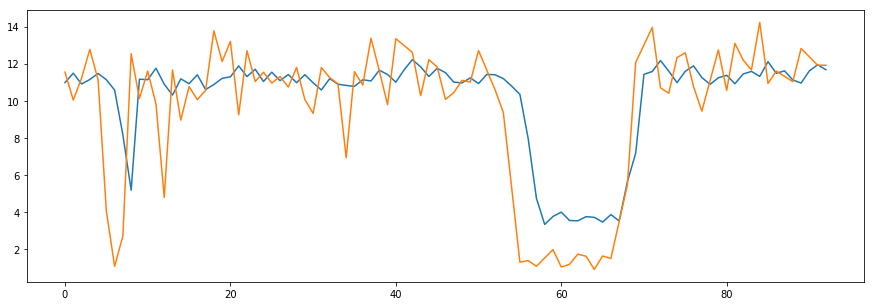

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]


plt.plot(output[:,23].detach().numpy())
plt.plot(target[:,23].detach().numpy())